# Classifying whether an ETF goes up or down
## Here we will use the data of the ETF we are prediciting and not any other data

#### Importing required libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [26]:
%run Feature_Creation.ipynb
%run Auxillary_Functions.ipynb
%run Classification_Function.ipynb


## Importing data

#### Importing data and generating features

In [4]:
SPY = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','largecap','SPY.csv'))

SPY_feat = create_features(SPY)

SPY_feat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month_1,Month_2,Month_3,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,2015-01-12,204.410004,204.600006,201.919998,202.649994,181.766663,144396100,1,0,0,...,False,False,2.0,3.0,0.0,2.0,2.0,1.0,-3.0,0.0
1,2015-01-13,204.119995,205.479996,200.509995,202.080002,181.255432,214553300,1,0,0,...,False,False,2.0,3.0,0.0,3.0,2.0,0.0,-3.0,1.0
2,2015-01-14,199.649994,201.100006,198.570007,200.860001,180.161163,192991100,1,0,0,...,False,False,2.0,3.0,0.0,4.0,2.0,-1.0,-3.0,2.0
3,2015-01-15,201.630005,202.009995,198.880005,199.020004,178.510773,176613900,1,0,0,...,False,True,2.0,3.0,0.0,5.0,2.0,-2.0,-3.0,3.0
4,2015-01-16,198.770004,201.820007,198.550003,201.630005,180.851807,211879600,1,0,0,...,False,False,2.0,5.0,1.0,0.0,1.0,5.0,-4.0,-2.0


#### Normalizing features

In [5]:
y = SPY_feat['target'].astype(int)
X = SPY_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)


X_test = X.iloc[1000:]
X_train = X.iloc[0:1000]
y_test = y.iloc[1000:]
y_train = y.iloc[0:1000]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x7fba3c8f0f20>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199] [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 23

# Analysis

# SPY

### Naive Prediction. Up everyday

In [6]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.592
accuracy score 0.592
f1 score 0.743718592964824


### Random Forests not tuned

0.488


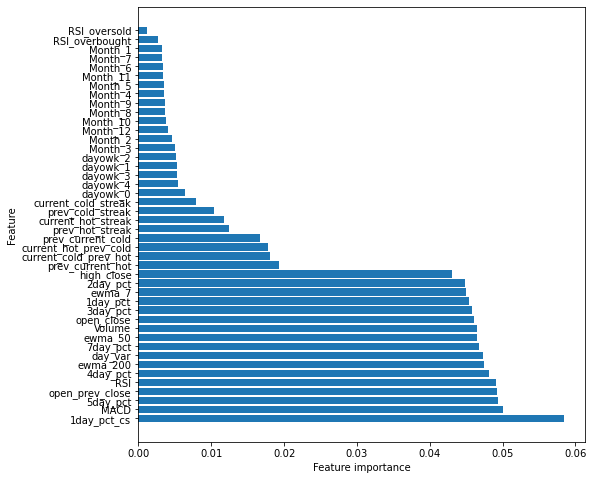

In [7]:
forest = RandomForestClassifier(n_estimators=3000, max_depth= 10)
forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))

plot_feature_importances(forest,n_features=50)

In [8]:
y_hat_test = forest.predict(X_test)
print('precision score' ,precision_score(y_hat_test,y_test))
print('recall score' ,recall_score(y_hat_test,y_test))
print('accuracy score' ,accuracy_score(y_hat_test,y_test))
print('f1 score' ,f1_score(y_hat_test,y_test))
print(y_test.value_counts()/y_test.value_counts().sum())

precision score 0.40540540540540543
recall score 0.6
accuracy score 0.488
f1 score 0.48387096774193555
1    0.592
0    0.408
Name: target, dtype: float64


### Random Forest tuned using GridSearch

In [26]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [5,7,10,30,50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5,10],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [3,5,9,13]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=tscv)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_
y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'model':'RF','precision':precision_score(y_hat_test_RF,y_test),'recall':recall_score(y_hat_test_RF,y_test),
           'accuracy':accuracy_score(y_hat_test_RF,y_test),'f1':f1_score(y_hat_test_RF,y_test),
           'return':np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2)))}

print(RF_dict)

#print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2))))

#print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*(np.array(y_hat_test_naive)))))

Training Accuracy: 54.38%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 13, 'min_samples_split': 5, 'n_estimators': 5}
{'model': 'RF', 'precision': 0.7094594594594594, 'recall': 0.6140350877192983, 'accuracy': 0.564, 'f1': 0.6583072100313481, 'return': 5.683357690038595}


In [27]:
best_rf['n_estimators']

5

In [35]:
RandomForestClassifier(n_estimators=best_rf['n_estimators'],
                       criterion = rf_grid_search.best_params_['criterion'],
                      max_depth= rf_grid_search.best_params_['max_depth']).fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=5)

### Logistic Regression

In [15]:
logreg_clf = LogisticRegression()
logreg_param_grid = {
    'fit_intercept': [True,False],
    'solver':['liblinear'],
    'C': np.logspace(0,4,5),
    'penalty': ['l2'],
}
logreg_grid_search = GridSearchCV(logreg_clf, logreg_param_grid, cv=tscv)
logreg_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {logreg_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {logreg_grid_search.best_params_}")

Training Accuracy: 51.62%

Optimal Parameters: {'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [16]:
y_hat_test_log = logreg_grid_search.predict(X_test)
logreg_poly_dict = {'model':'SVM_poly','precision':precision_score(y_hat_test_log,y_test),
                    'recall':recall_score(y_hat_test_log,y_test),
                   'accuracy':accuracy_score(y_hat_test_log,y_test),
                    'f1':f1_score(y_hat_test_log,y_test),
                   'return':np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2)))}

In [17]:
logreg_poly_dict

{'model': 'SVM_poly',
 'precision': 0.41216216216216217,
 'recall': 0.6161616161616161,
 'accuracy': 0.5,
 'f1': 0.49392712550607293}

## SVM

In [18]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)

SVC(kernel='linear')

In [19]:
svm_clf = svm.SVC()
C_range = np.array([50., 100., 200., 500.])
gamma_range = np.array([0.0001,3*0.0001,0.001,3*0.001])
svm_param_grid = dict(gamma=gamma_range, C=C_range)

svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=tscv)
svm_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {svm_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svm_grid_search.best_params_}")

Training Accuracy: 55.00%

Optimal Parameters: {'C': 100.0, 'gamma': 0.0001}


In [20]:
y_hat_test_svm = svm_grid_search.predict(X_test)
SVM_dict = {'model':'SVM','precision':precision_score(y_hat_test_svm,y_test),'recall':recall_score(y_hat_test_svm,y_test),
           'accuracy':accuracy_score(y_hat_test_svm,y_test),'f1':f1_score(y_hat_test_svm,y_test)}

In [21]:
SVM_dict

{'model': 'SVM',
 'precision': 0.8175675675675675,
 'recall': 0.5931372549019608,
 'accuracy': 0.56,
 'f1': 0.6874999999999999}

In [22]:
svm_clf_poly = svm.SVC(kernel='poly')
r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  np.array([0.0001,0.001, 0.01,0.1])
d_range = np.array([2,3, 4])
param_grid = dict(gamma=gamma_range, degree=d_range, coef0=r_range)
svm_grid_search_poly = GridSearchCV(svm_clf_poly, param_grid, cv=tscv)
svm_grid_search_poly.fit(X_train, y_train)

print(f"Training Accuracy: {svm_grid_search_poly.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svm_grid_search_poly.best_params_}")

Training Accuracy: 55.12%

Optimal Parameters: {'coef0': 4.0, 'degree': 4, 'gamma': 0.0001}


In [23]:
y_hat_test_svm_poly = svm_grid_search_poly.predict(X_test)
SVM_poly_dict = {'model':'SVM_poly','precision':precision_score(y_hat_test_svm_poly,y_test),'recall':recall_score(y_hat_test_svm_poly,y_test),
           'accuracy':accuracy_score(y_hat_test_svm_poly,y_test),'f1':f1_score(y_hat_test_svm_poly,y_test)}

In [24]:
SVM_poly_dict

{'model': 'SVM_poly',
 'precision': 0.7905405405405406,
 'recall': 0.5879396984924623,
 'accuracy': 0.548,
 'f1': 0.6743515850144092}

In [25]:
np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_svm)-1/2)*2)))

11.120800232893803

## Gradient Boosting Classifier

In [26]:
model = XGBClassifier()

In [27]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
model.score(X_test,y_test)

0.52

In [29]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=2,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 120, 10),
    'learning_rate': [0.001,0.003,0.01, 0.03, 0.1]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 10,
    cv = tscv,
    verbose=True
)
grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

y_hat_test_XGB = grid_search.predict(X_test)
XGB_dict = {'model':'XGB','precision':precision_score(y_hat_test_XGB,y_test),'recall':recall_score(y_hat_test_XGB,y_test),
           'accuracy':accuracy_score(y_hat_test_XGB,y_test),'f1':f1_score(y_hat_test_XGB,y_test)}

print(XGB_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_XGB)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*np.ones(len(y_test)))))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   22.3s


Training Accuracy: 53.50%

Optimal Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.581081081081081, 'recall': 0.6466165413533834, 'accuracy': 0.564, 'f1': 0.6120996441281138}
29.14715184346195
19.214327287585224


[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   42.6s finished


## Voting

In [32]:
voted_y = []
for i in range(len(y_test)):
    l = np.array([y_hat_test_RF[i],y_hat_test_log[i],y_hat_test_svm[i],y_hat_test_XGB[i]])
    counts = np.bincount(l)
    voted_y.append(np.argmax(counts))
voted_y = np.array(voted_y)
voted_dict = {'model':'Stacked','precision':precision_score(voted_y,y_test),'recall':recall_score(voted_y,y_test),
           'accuracy':accuracy_score(voted_y,y_test),'f1':f1_score(voted_y,y_test)}

In [33]:
voted_dict

{'model': 'Stacked',
 'precision': 0.5337837837837838,
 'recall': 0.5766423357664233,
 'accuracy': 0.492,
 'f1': 0.5543859649122806}

## Stacked Ananlysis

# Gold Predictions XGB

In [64]:
GLD = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','other','gold.csv'))

GLD_feat = create_features(GLD)

GLD_feat.head()

KeyError: 2

In [29]:
y = GLD_feat['target'].astype(int)
X = GLD_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)

train_size = X.shape[0]*4//5
X_test = X.iloc[train_size:]
X_train = X.iloc[0:train_size]
y_test = y.iloc[train_size:]
y_train = y.iloc[0:train_size]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x00000207A29FB390>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172] [173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 23

### Naive Prediction. Trade based on previous day only

In [30]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.5529953917050692
accuracy score 0.5529953917050692
f1 score 0.712166172106825


## Random Forest Grid Search

In [31]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100,200,300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5,10,12,15],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [2,3,5,9,13]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=tscv)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'model':'RF','precision':precision_score(y_hat_test_RF,y_test),'recall':recall_score(y_hat_test_RF,y_test),
           'accuracy':accuracy_score(y_hat_test_RF,y_test),'f1':f1_score(y_hat_test_RF,y_test)}

print(RF_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*(np.array(y_hat_test_naive)))))

Training Accuracy: 63.87%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
{'model': 'RF', 'precision': 0.15, 'recall': 0.6666666666666666, 'accuracy': 0.48847926267281105, 'f1': 0.24489795918367346}
-6.2060468006896405
12.423081851806517


## XGB Classifier

In [32]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=2,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 120, 10),
    'learning_rate': [0.001,0.003,0.01, 0.03, 0.1]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 10,
    cv = tscv,
    verbose=True
)
grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

y_hat_test_XGB = grid_search.predict(X_test)
XGB_dict = {'model':'XGB','precision':precision_score(y_hat_test_XGB,y_test),'recall':recall_score(y_hat_test_XGB,y_test),
           'accuracy':accuracy_score(y_hat_test_XGB,y_test),'f1':f1_score(y_hat_test_XGB,y_test)}

print(XGB_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_XGB)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*np.ones(len(y_test)))))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   33.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:  3.6min finished


Training Accuracy: 62.86%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.15833333333333333, 'recall': 0.5135135135135135, 'accuracy': 0.45161290322580644, 'f1': 0.24203821656050953}
-15.875026897509608
12.423081851806517


# Random Predictions

In [15]:
RND = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','largecap','random.csv'))
RND.drop('Unnamed: 0',axis=1,inplace=True)
#RND.columns
RND_feat = create_features(RND)

RND_feat.head()

,Date,Adj Close,Close,Open,High,Low,Volume,Month_1,Month_2,Month_3,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,2015-01-12,1.008302,1.008302,1.008415,1.011225,0.996944,105034700,1,0,0,...,False,False,3.0,1.0,1.0,0.0,2.0,1.0,0.0,-3.0
1,2015-01-13,1.009812,1.009812,0.997478,1.010654,1.008826,36663300,1,0,0,...,False,False,3.0,1.0,2.0,0.0,1.0,1.0,1.0,-3.0
2,2015-01-14,1.007294,1.007294,0.993860,1.010478,1.005501,93519900,1,0,0,...,False,False,2.0,1.0,0.0,1.0,2.0,0.0,-1.0,-1.0
3,2015-01-15,1.020514,1.020514,1.028115,1.022974,1.018992,62877600,1,0,0,...,True,False,2.0,1.0,1.0,0.0,1.0,1.0,0.0,-2.0
4,2015-01-16,1.025327,1.025327,1.037494,1.035990,1.025055,85548900,1,0,0,...,True,False,2.0,1.0,2.0,0.0,0.0,1.0,1.0,-2.0


In [24]:
RND_feat.columns

Index(['Date', 'Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4', '1day_pct',
       '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       '1day_pct_cs', 'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD',
       'day_var', 'open_close', 'high_close', 'open_prev_close', 'target',
       'RSI_overbought', 'RSI_oversold', 'prev_hot_streak', 'prev_cold_streak',
       'current_hot_streak', 'current_cold_streak', 'prev_current_hot',
       'prev_current_cold', 'current_hot_prev_cold', 'current_cold_prev_hot'],
      dtype='object')

In [25]:
y = RND_feat['target'].astype(int)
X = RND_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)

train_size = X.shape[0]*4//5
X_test = X.iloc[train_size:]
X_train = X.iloc[0:train_size]
y_test = y.iloc[train_size:]
y_train = y.iloc[0:train_size]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x0000025A9FC3FED0>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199] [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 23

In [26]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.472
accuracy score 0.472
f1 score 0.6413043478260869


        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  204.410004  204.600006  201.919998  202.649994  181.766663   
1 2015-01-13  204.119995  205.479996  200.509995  202.080002  181.255432   
2 2015-01-14  199.649994  201.100006  198.570007  200.860001  180.161163   
3 2015-01-15  201.630005  202.009995  198.880005  199.020004  178.510773   
4 2015-01-16  198.770004  201.820007  198.550003  201.630005  180.851807   

      Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0  144396100        1        0        0  ...           False         False   
1  214553300        1        0        0  ...           False         False   
2  192991100        1        0        0  ...           False         False   
3  176613900        1        0        0  ...           False          True   
4  211879600        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_str

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   21.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   33.5s
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   43.5s finished


Training Accuracy: 53.50%

Optimal Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.581081081081081, 'recall': 0.6466165413533834, 'accuracy': 0.564, 'f1': 0.6120996441281138, 'return': 29.14715184346195}
{'model': 'stack', 'precision': 0.9797297297297297, 'recall': 0.5918367346938775, 'accuracy': 0.588, 'f1': 0.737913486005089, 'return': 19.867981080548883}


({'model': 'RF',
  'precision': 0.8175675675675675,
  'recall': 0.5931372549019608,
  'accuracy': 0.56,
  'f1': 0.6874999999999999,
  'return': 13.785209547213356},
 {'model': 'Logistic',
  'precision': 0.527027027027027,
  'recall': 0.5531914893617021,
  'accuracy': 0.468,
  'f1': 0.5397923875432526,
  'return': -9.329081375106462},
 {'model': 'SVM_poly',
  'precision': 0.7905405405405406,
  'recall': 0.5879396984924623,
  'accuracy': 0.548,
  'f1': 0.6743515850144092,
  'return': 8.184370386040785},
 {'model': 'XGB',
  'precision': 0.581081081081081,
  'recall': 0.6466165413533834,
  'accuracy': 0.564,
  'f1': 0.6120996441281138,
  'return': 29.14715184346195},
 {'model': 'stack',
  'precision': 0.9797297297297297,
  'recall': 0.5918367346938775,
  'accuracy': 0.588,
  'f1': 0.737913486005089,
  'return': 19.867981080548883})

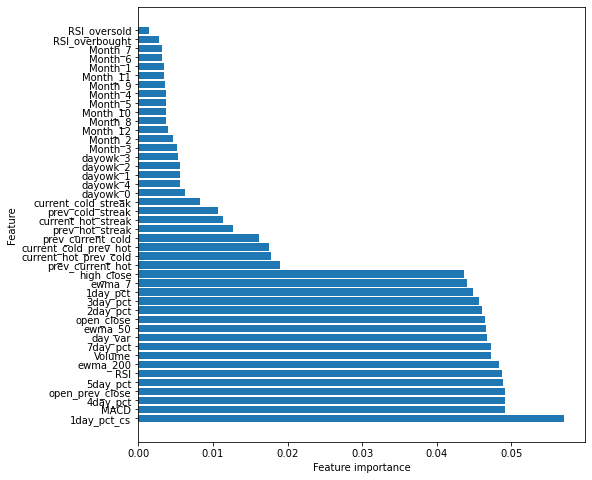

In [44]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','largecap','SPY.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.008302  1.008302  1.008415  1.011225  0.996944   
1           8 2015-01-13   1.009812  1.009812  0.997478  1.010654  1.008826   
2           9 2015-01-14   1.007294  1.007294  0.993860  1.010478  1.005501   
3          10 2015-01-15   1.020514  1.020514  1.028115  1.022974  1.018992   
4          11 2015-01-16   1.025327  1.025327  1.037494  1.035990  1.025055   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  105034700        1        0  ...           False         False   
1   36663300        1        0  ...           False         False   
2   93519900        1        0  ...           False         False   
3   62877600        1        0  ...            True         False   
4   85548900        1        0  ...            True         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              3.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 290 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 790 tasks      | elapsed:   18.8s
[Parallel(n_jobs=10)]: Done 1490 tasks      | elapsed:   34.5s
[Parallel(n_jobs=10)]: Done 1581 out of 1600 | elapsed:   37.5s remaining:    0.5s
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   38.2s finished


Training Accuracy: 52.75%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 70}
{'model': 'XGB', 'precision': 0.3559322033898305, 'recall': 0.5, 'accuracy': 0.528, 'f1': 0.4158415841584159, 'return': 4.467850637869371}
{'model': 'stack', 'precision': 0.1271186440677966, 'recall': 0.45454545454545453, 'accuracy': 0.516, 'f1': 0.19867549668874174, 'return': -2.310985671937477}


({'model': 'RF',
  'precision': 0.4406779661016949,
  'recall': 0.5148514851485149,
  'accuracy': 0.54,
  'f1': 0.4748858447488585,
  'return': 28.050077643954104},
 {'model': 'Logistic',
  'precision': 0.3898305084745763,
  'recall': 0.46464646464646464,
  'accuracy': 0.5,
  'f1': 0.42396313364055305,
  'return': 8.3278360120444},
 {'model': 'SVM_poly',
  'precision': 0.423728813559322,
  'recall': 0.43478260869565216,
  'accuracy': 0.468,
  'f1': 0.42918454935622313,
  'return': -19.33803323914678},
 {'model': 'XGB',
  'precision': 0.3559322033898305,
  'recall': 0.5,
  'accuracy': 0.528,
  'f1': 0.4158415841584159,
  'return': 4.467850637869371},
 {'model': 'stack',
  'precision': 0.1271186440677966,
  'recall': 0.45454545454545453,
  'accuracy': 0.516,
  'f1': 0.19867549668874174,
  'return': -2.310985671937477})

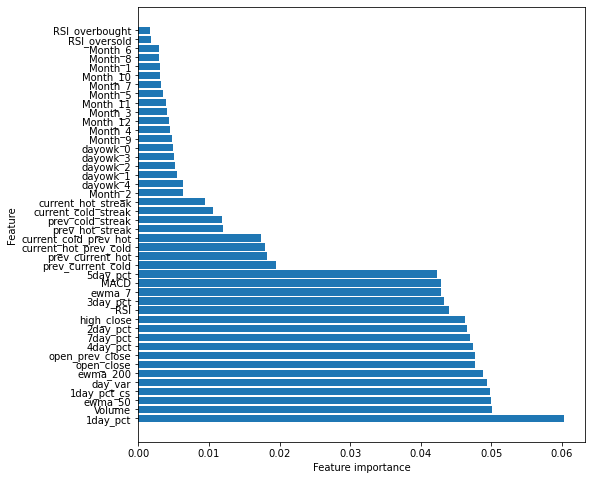

In [45]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','largecap','random.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  187.460007  187.600006  185.190002  185.839996  166.401184   
1 2015-01-13  187.220001  188.410004  183.899994  185.350006  165.962463   
2 2015-01-14  183.100006  184.399994  182.110001  184.259995  164.986465   
3 2015-01-15  184.880005  185.250000  182.399994  182.539993  163.446381   
4 2015-01-16  182.309998  185.080002  182.089996  184.800003  165.470032   

    Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0  1847500        1        0        0  ...           False         False   
1  2158500        1        0        0  ...           False         False   
2  5216300        1        0        0  ...           False         False   
3  1940700        1        0        0  ...           False          True   
4  1472800        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   21.8s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   39.4s


Training Accuracy: 53.38%

Optimal Parameters: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 20}
{'model': 'XGB', 'precision': 0.8648648648648649, 'recall': 0.5844748858447488, 'accuracy': 0.556, 'f1': 0.6975476839237057, 'return': 13.61405519377871}


[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   41.6s finished


({'model': 'RF',
  'precision': 0.9594594594594594,
  'recall': 0.5892116182572614,
  'accuracy': 0.58,
  'f1': 0.7300771208226221,
  'return': 17.10449121913554},
 {'model': 'Logistic',
  'precision': 0.5405405405405406,
  'recall': 0.5714285714285714,
  'accuracy': 0.488,
  'f1': 0.5555555555555556,
  'return': -0.4646076306175946},
 {'model': 'SVM_poly',
  'precision': 0.8648648648648649,
  'recall': 0.5925925925925926,
  'accuracy': 0.568,
  'f1': 0.7032967032967032,
  'return': 13.94595779093425},
 {'model': 'XGB',
  'precision': 0.8648648648648649,
  'recall': 0.5844748858447488,
  'accuracy': 0.556,
  'f1': 0.6975476839237057,
  'return': 13.61405519377871})

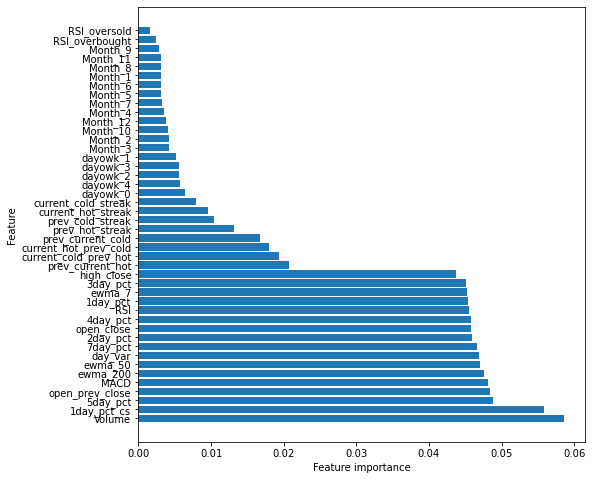

In [61]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','largecap','VOO.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  205.850006  206.029999  203.350006  204.089996  182.042572   
1 2015-01-13  205.559998  206.910004  201.949997  203.559998  181.569855   
2 2015-01-14  201.050003  202.490005  199.970001  202.330002  180.472702   
3 2015-01-15  203.029999  203.419998  200.279999  200.429993  178.777969   
4 2015-01-16  200.179993  203.229996  199.949997  203.000000  181.070328   

    Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0  3501600        1        0        0  ...           False         False   
1  8469500        1        0        0  ...           False         False   
2  8016900        1        0        0  ...           False         False   
3  8726300        1        0        0  ...           False          True   
4  4981700        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 290 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 790 tasks      | elapsed:   21.5s
[Parallel(n_jobs=10)]: Done 1490 tasks      | elapsed:   38.4s
[Parallel(n_jobs=10)]: Done 1581 out of 1600 | elapsed:   41.4s remaining:    0.5s


Training Accuracy: 52.88%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 60}
{'model': 'XGB', 'precision': 0.3673469387755102, 'recall': 0.5934065934065934, 'accuracy': 0.48, 'f1': 0.453781512605042, 'return': -34.654435008411994}


[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   42.0s finished


({'model': 'RF',
  'precision': 0.5238095238095238,
  'recall': 0.5833333333333334,
  'accuracy': 0.5,
  'f1': 0.5519713261648745,
  'return': 1.9508329944708107},
 {'model': 'Logistic',
  'precision': 0.5782312925170068,
  'recall': 0.5704697986577181,
  'accuracy': 0.496,
  'f1': 0.5743243243243242,
  'return': 0.6703980349758716},
 {'model': 'SVM_poly',
  'precision': 0.8231292517006803,
  'recall': 0.5960591133004927,
  'accuracy': 0.568,
  'f1': 0.6914285714285714,
  'return': 12.169712449685722},
 {'model': 'XGB',
  'precision': 0.3673469387755102,
  'recall': 0.5934065934065934,
  'accuracy': 0.48,
  'f1': 0.453781512605042,
  'return': -34.654435008411994})

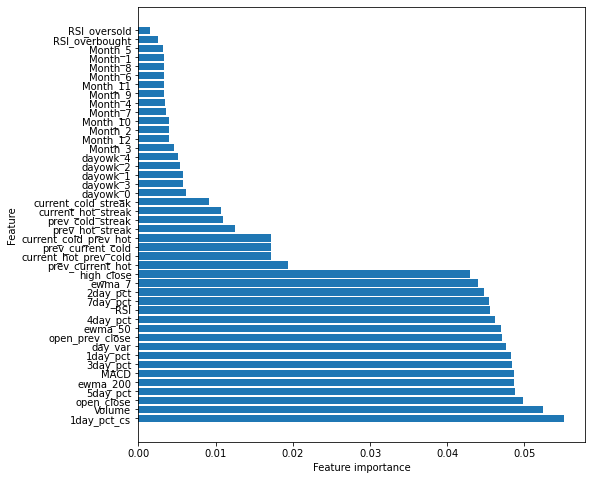

In [66]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','largecap','IVV.csv')
daily_prediction_analysis(fname)

        Date       Open       High        Low      Close  Adj Close    Volume  \
0 2015-01-12  75.389999  75.389999  73.760002  74.160004  59.673450  28940600   
1 2015-01-13  74.459999  75.040001  72.879997  73.570000  59.198700  34051400   
2 2015-01-14  72.870003  73.910004  71.699997  73.800003  59.383778  52152500   
3 2015-01-15  74.669998  74.860001  72.800003  72.860001  58.627396  41346000   
4 2015-01-16  73.290001  75.330002  73.230003  75.230003  60.534447  42741900   

   Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0        1        0        0  ...           False          True   
1        1        0        0  ...           False          True   
2        1        0        0  ...           False          True   
3        1        0        0  ...           False          True   
4        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              2.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   19.1s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   37.0s


Training Accuracy: 54.88%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.3712121212121212, 'recall': 0.48514851485148514, 'accuracy': 0.46, 'f1': 0.4206008583690987, 'return': -7.900983934725948}


[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   39.1s finished


({'model': 'RF',
  'precision': 0.4166666666666667,
  'recall': 0.5092592592592593,
  'accuracy': 0.48,
  'f1': 0.4583333333333333,
  'return': -5.424315482963985},
 {'model': 'Logistic',
  'precision': 0.29545454545454547,
  'recall': 0.4936708860759494,
  'accuracy': 0.468,
  'f1': 0.3696682464454977,
  'return': -17.108761781699627},
 {'model': 'SVM_poly',
  'precision': 0.3939393939393939,
  'recall': 0.5252525252525253,
  'accuracy': 0.492,
  'f1': 0.45021645021645024,
  'return': -0.03706520400860569},
 {'model': 'XGB',
  'precision': 0.3712121212121212,
  'recall': 0.48514851485148514,
  'accuracy': 0.46,
  'f1': 0.4206008583690987,
  'return': -7.900983934725948})

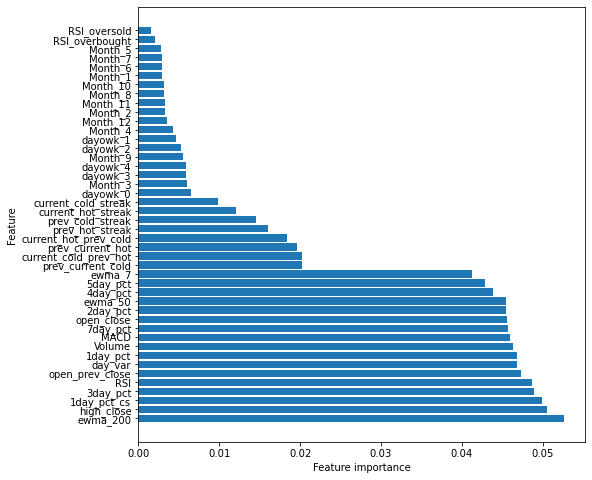

In [67]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','energy','XLE.csv')
daily_prediction_analysis(fname)

        Date       Open       High        Low      Close  Adj Close    Volume  \
0 2015-01-12  70.750000  71.000000  70.050003  70.239998  64.028023  11972100   
1 2015-01-13  70.900002  71.290001  69.339996  69.930000  63.745449  14219800   
2 2015-01-14  69.260002  70.000000  69.070000  69.820000  63.645199  12548000   
3 2015-01-15  70.080002  70.209999  69.029999  69.070000  62.961517  16382800   
4 2015-01-16  68.959999  70.500000  68.940002  70.370003  64.146545  13759300   

   Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0        1        0        0  ...            True         False   
1        1        0        0  ...           False         False   
2        1        0        0  ...           False         False   
3        1        0        0  ...           False         False   
4        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              2.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   19.0s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   35.8s


Training Accuracy: 57.12%

Optimal Parameters: {'learning_rate': 0.003, 'max_depth': 2, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.9366197183098591, 'recall': 0.5833333333333334, 'accuracy': 0.584, 'f1': 0.7189189189189189, 'return': 14.336860084176013}


[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:   37.9s finished


({'model': 'RF',
  'precision': 0.9154929577464789,
  'recall': 0.5855855855855856,
  'accuracy': 0.584,
  'f1': 0.7142857142857143,
  'return': 14.991640753141926},
 {'model': 'Logistic',
  'precision': 0.8943661971830986,
  'recall': 0.5619469026548672,
  'accuracy': 0.544,
  'f1': 0.6902173913043479,
  'return': 1.6883731865727718},
 {'model': 'SVM_poly',
  'precision': 1.0,
  'recall': 0.568,
  'accuracy': 0.568,
  'f1': 0.7244897959183673,
  'return': 11.813299884642424},
 {'model': 'XGB',
  'precision': 0.9366197183098591,
  'recall': 0.5833333333333334,
  'accuracy': 0.584,
  'f1': 0.7189189189189189,
  'return': 14.336860084176013})

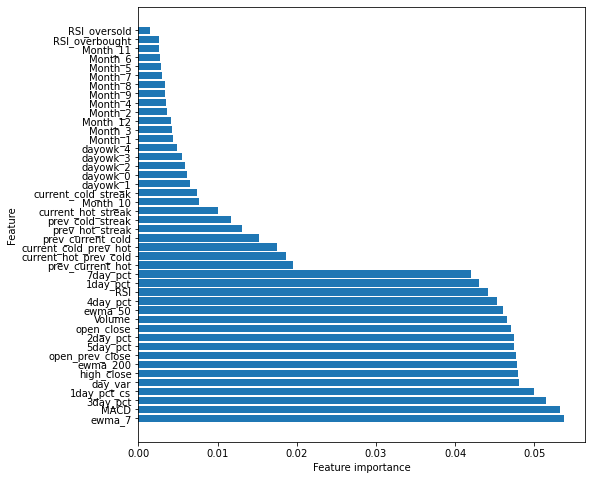

In [68]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','health','XLV.csv')
daily_prediction_analysis(fname)

In [14]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','GLD.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  117.459999  118.709999  117.320000  118.559998  118.559998   
1 2015-01-13  118.959999  119.190002  117.870003  118.160004  118.160004   
2 2015-01-14  119.080002  119.320000  117.900002  117.970001  117.970001   
3 2015-01-15  120.410004  121.699997  120.339996  120.940002  120.940002   
4 2015-01-16  121.730003  123.150002  121.709999  122.519997  122.519997   

     Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0   8318200        1        0        0  ...            True         False   
1   7693200        1        0        0  ...            True         False   
2   7727400        1        0        0  ...            True         False   
3  17692500        1        0        0  ...            True         False   
4  14428200        1        0        0  ...            True         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 600 tasks      | elapsed:   19.9s
[Parallel(n_jobs=10)]: Done 950 tasks      | elapsed:   33.0s
[Parallel(n_jobs=10)]: Done 1400 tasks      | elapsed:   50.1s
[Parallel(n_jobs=10)]: Done 1950 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 54.10%

Optimal Parameters: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.6692307692307692, 'recall': 0.5087719298245614, 'accuracy': 0.492, 'f1': 0.5780730897009966, 'return': 10.914556063929005}
{'model': 'stack', 'precision': 0.9461538461538461, 'recall': 0.5168067226890757, 'accuracy': 0.512, 'f1': 0.6684782608695652, 'return': -9.459003882101202}


({'model': 'RF',
  'precision': 0.5538461538461539,
  'recall': 0.5333333333333333,
  'accuracy': 0.516,
  'f1': 0.5433962264150943,
  'return': 3.8708217458592653},
 {'model': 'Logistic',
  'precision': 0.5846153846153846,
  'recall': 0.5588235294117647,
  'accuracy': 0.544,
  'f1': 0.5714285714285715,
  'return': 45.06371395545608},
 {'model': 'SVM_poly',
  'precision': 0.823076923076923,
  'recall': 0.535,
  'accuracy': 0.536,
  'f1': 0.6484848484848486,
  'return': 10.625251167163063},
 {'model': 'XGB',
  'precision': 0.6692307692307692,
  'recall': 0.5087719298245614,
  'accuracy': 0.492,
  'f1': 0.5780730897009966,
  'return': 10.914556063929005},
 {'model': 'stack',
  'precision': 0.9461538461538461,
  'recall': 0.5168067226890757,
  'accuracy': 0.512,
  'f1': 0.6684782608695652,
  'return': -9.459003882101202})

In [15]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random1.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   0.991195  0.991195  1.000550  0.994688  0.985314   
1           8 2015-01-13   0.995615  0.995615  1.000200  0.999193  0.992750   
2           9 2015-01-14   0.999490  0.999490  1.001010  1.001477  0.997761   
3          10 2015-01-15   1.005221  1.005221  1.011141  1.020030  1.000606   
4          11 2015-01-16   1.018237  1.018237  1.018951  1.018803  1.001674   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  101275600        1        0  ...           False         False   
1   61903800        1        0  ...           False         False   
2   86265800        1        0  ...           False         False   
3   65838700        1        0  ...           False         False   
4  162401500        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              3.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 338 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done 590 tasks      | elapsed:   21.9s
[Parallel(n_jobs=10)]: Done 940 tasks      | elapsed:   36.3s
[Parallel(n_jobs=10)]: Done 1390 tasks      | elapsed:   53.9s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 54.30%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.5037593984962406, 'recall': 0.536, 'accuracy': 0.504, 'f1': 0.5193798449612403, 'return': -6.325186316147557}
{'model': 'stack', 'precision': 0.6766917293233082, 'recall': 0.5357142857142857, 'accuracy': 0.516, 'f1': 0.5980066445182725, 'return': -7.94637603753763}


({'model': 'RF',
  'precision': 0.5939849624060151,
  'recall': 0.512987012987013,
  'accuracy': 0.484,
  'f1': 0.5505226480836237,
  'return': -1.3042007420066941},
 {'model': 'Logistic',
  'precision': 0.5413533834586466,
  'recall': 0.5454545454545454,
  'accuracy': 0.516,
  'f1': 0.5433962264150943,
  'return': 3.4088335572279136},
 {'model': 'SVM_poly',
  'precision': 0.5263157894736842,
  'recall': 0.48951048951048953,
  'accuracy': 0.456,
  'f1': 0.5072463768115942,
  'return': 14.793546088379149},
 {'model': 'XGB',
  'precision': 0.5037593984962406,
  'recall': 0.536,
  'accuracy': 0.504,
  'f1': 0.5193798449612403,
  'return': -6.325186316147557},
 {'model': 'stack',
  'precision': 0.6766917293233082,
  'recall': 0.5357142857142857,
  'accuracy': 0.516,
  'f1': 0.5980066445182725,
  'return': -7.94637603753763})

In [16]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random2.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.000883  1.000883  0.996297  1.007041  1.000831   
1           8 2015-01-13   1.000305  1.000305  1.001973  1.001205  0.996635   
2           9 2015-01-14   1.000858  1.000858  0.996747  1.001598  0.990011   
3          10 2015-01-15   0.994789  0.994789  0.995467  0.998964  0.988048   
4          11 2015-01-16   1.004490  1.004490  0.996246  1.012518  1.003691   

     Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  97307400        1        0  ...           False         False   
1  60067000        1        0  ...           False         False   
2  58892500        1        0  ...           False         False   
3  81503900        1        0  ...           False         False   
4  64211200        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              1.0               3.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 600 tasks      | elapsed:   20.0s
[Parallel(n_jobs=10)]: Done 950 tasks      | elapsed:   33.9s
[Parallel(n_jobs=10)]: Done 1400 tasks      | elapsed:   51.3s
[Parallel(n_jobs=10)]: Done 1950 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 55.00%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 110}
{'model': 'XGB', 'precision': 0.496, 'recall': 0.512396694214876, 'accuracy': 0.512, 'f1': 0.5040650406504064, 'return': 8.395649334171173}
{'model': 'stack', 'precision': 0.624, 'recall': 0.4936708860759494, 'accuracy': 0.492, 'f1': 0.5512367491166077, 'return': 1.6176108938911433}


({'model': 'RF',
  'precision': 0.552,
  'recall': 0.5227272727272727,
  'accuracy': 0.524,
  'f1': 0.5369649805447471,
  'return': -5.200343430283722},
 {'model': 'Logistic',
  'precision': 0.52,
  'recall': 0.5241935483870968,
  'accuracy': 0.524,
  'f1': 0.5220883534136547,
  'return': 8.127272995157957},
 {'model': 'SVM_poly',
  'precision': 0.88,
  'recall': 0.4954954954954955,
  'accuracy': 0.492,
  'f1': 0.6340057636887608,
  'return': 15.883007274135629},
 {'model': 'XGB',
  'precision': 0.496,
  'recall': 0.512396694214876,
  'accuracy': 0.512,
  'f1': 0.5040650406504064,
  'return': 8.395649334171173},
 {'model': 'stack',
  'precision': 0.624,
  'recall': 0.4936708860759494,
  'accuracy': 0.492,
  'f1': 0.5512367491166077,
  'return': 1.6176108938911433})

In [17]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random3.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.003139  1.003139  0.989520  1.004266  0.995814   
1           8 2015-01-13   1.018927  1.018927  1.023671  1.039766  1.016016   
2           9 2015-01-14   1.006923  1.006923  0.996372  1.007353  1.004622   
3          10 2015-01-15   0.998862  0.998862  1.002532  1.016135  0.996185   
4          11 2015-01-16   0.994704  0.994704  0.990677  0.994799  0.993024   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0   88939300        1        0  ...           False         False   
1  116128900        1        0  ...            True         False   
2  110145700        1        0  ...           False         False   
3  131809300        1        0  ...           False         False   
4   44778800        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              3.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   18.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   48.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 52.90%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
{'model': 'XGB', 'precision': 0.515625, 'recall': 0.49624060150375937, 'accuracy': 0.484, 'f1': 0.5057471264367815, 'return': 22.406157844708332}
{'model': 'stack', 'precision': 0.3046875, 'recall': 0.46987951807228917, 'accuracy': 0.468, 'f1': 0.3696682464454976, 'return': 21.663706410380936}


({'model': 'RF',
  'precision': 0.5,
  'recall': 0.5,
  'accuracy': 0.488,
  'f1': 0.5,
  'return': 8.90725077094455},
 {'model': 'Logistic',
  'precision': 0.5546875,
  'recall': 0.5503875968992248,
  'accuracy': 0.54,
  'f1': 0.5525291828793774,
  'return': 14.0107189661687},
 {'model': 'SVM_poly',
  'precision': 0.578125,
  'recall': 0.5362318840579711,
  'accuracy': 0.528,
  'f1': 0.556390977443609,
  'return': 3.2381463253413267},
 {'model': 'XGB',
  'precision': 0.515625,
  'recall': 0.49624060150375937,
  'accuracy': 0.484,
  'f1': 0.5057471264367815,
  'return': 22.406157844708332},
 {'model': 'stack',
  'precision': 0.3046875,
  'recall': 0.46987951807228917,
  'accuracy': 0.468,
  'f1': 0.3696682464454976,
  'return': 21.663706410380936})

In [18]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random4.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.012496  1.012496  1.008585  1.013507  1.010236   
1           8 2015-01-13   1.010802  1.010802  1.009623  1.011213  1.010111   
2           9 2015-01-14   1.006021  1.006021  1.009614  1.008938  0.992522   
3          10 2015-01-15   1.006034  1.006034  0.998142  1.024376  1.003465   
4          11 2015-01-16   1.010403  1.010403  1.016840  1.010523  1.008183   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  211003300        1        0  ...           False         False   
1  153100200        1        0  ...           False         False   
2   78448500        1        0  ...           False         False   
3   95555300        1        0  ...           False         False   
4   91230900        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              4.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   18.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   32.4s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   50.1s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 53.00%

Optimal Parameters: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 70}
{'model': 'XGB', 'precision': 0.4852941176470588, 'recall': 0.5196850393700787, 'accuracy': 0.476, 'f1': 0.5019011406844106, 'return': -1.1071965918696438}
{'model': 'stack', 'precision': 0.9705882352941176, 'recall': 0.5387755102040817, 'accuracy': 0.532, 'f1': 0.6929133858267718, 'return': 17.45304166851533}


({'model': 'RF',
  'precision': 0.6029411764705882,
  'recall': 0.5466666666666666,
  'accuracy': 0.512,
  'f1': 0.5734265734265734,
  'return': -5.168798137838634},
 {'model': 'Logistic',
  'precision': 0.4338235294117647,
  'recall': 0.5,
  'accuracy': 0.456,
  'f1': 0.4645669291338583,
  'return': -14.128312822502458},
 {'model': 'SVM_poly',
  'precision': 1.0,
  'recall': 0.544,
  'accuracy': 0.544,
  'f1': 0.7046632124352332,
  'return': 12.599487136180608},
 {'model': 'XGB',
  'precision': 0.4852941176470588,
  'recall': 0.5196850393700787,
  'accuracy': 0.476,
  'f1': 0.5019011406844106,
  'return': -1.1071965918696438},
 {'model': 'stack',
  'precision': 0.9705882352941176,
  'recall': 0.5387755102040817,
  'accuracy': 0.532,
  'f1': 0.6929133858267718,
  'return': 17.45304166851533})

In [20]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random5.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   0.991296  0.991296  1.001737  0.991937  0.989771   
1           8 2015-01-13   0.982143  0.982143  0.982011  0.983178  0.973299   
2           9 2015-01-14   0.991240  0.991240  0.989458  0.992168  0.990060   
3          10 2015-01-15   0.972708  0.972708  0.966780  0.974191  0.967375   
4          11 2015-01-16   0.968842  0.968842  0.964362  0.971277  0.965113   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0   91366500        1        0  ...           False         False   
1  124384200        1        0  ...           False          True   
2   57751000        1        0  ...           False         False   
3  172946000        1        0  ...           False          True   
4  106949700        1        0  ...           False          True   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              1.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 337 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done 590 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done 940 tasks      | elapsed:   33.6s
[Parallel(n_jobs=10)]: Done 1390 tasks      | elapsed:   50.4s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 53.80%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 70}
{'model': 'XGB', 'precision': 0.4462809917355372, 'recall': 0.5510204081632653, 'accuracy': 0.556, 'f1': 0.4931506849315068, 'return': -7.723665902456009}
{'model': 'stack', 'precision': 0.0, 'recall': 0.0, 'accuracy': 0.516, 'f1': 0.0, 'return': -5.730385274258476}


({'model': 'RF',
  'precision': 0.08264462809917356,
  'recall': 0.35714285714285715,
  'accuracy': 0.484,
  'f1': 0.1342281879194631,
  'return': -5.429547304419257},
 {'model': 'Logistic',
  'precision': 0.4297520661157025,
  'recall': 0.49056603773584906,
  'accuracy': 0.508,
  'f1': 0.4581497797356828,
  'return': -17.268526438329108},
 {'model': 'SVM_poly',
  'precision': 0.4628099173553719,
  'recall': 0.509090909090909,
  'accuracy': 0.524,
  'f1': 0.4848484848484848,
  'return': -16.028794939575327},
 {'model': 'XGB',
  'precision': 0.4462809917355372,
  'recall': 0.5510204081632653,
  'accuracy': 0.556,
  'f1': 0.4931506849315068,
  'return': -7.723665902456009},
 {'model': 'stack',
  'precision': 0.0,
  'recall': 0.0,
  'accuracy': 0.516,
  'f1': 0.0,
  'return': -5.730385274258476})

In [27]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','LQD.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  120.940002  121.190002  120.870003  121.129997   99.597038   
1 2015-01-13  121.129997  121.279999  120.910004  121.239998   99.687477   
2 2015-01-14  121.709999  121.820000  121.349998  121.449997   99.860092   
3 2015-01-15  121.529999  122.269997  121.449997  122.080002  100.378098   
4 2015-01-16  121.709999  121.910004  121.230003  121.400002   99.818977   

    Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0  1948000        1        0        0  ...            True         False   
1  1468300        1        0        0  ...            True         False   
2  2457000        1        0        0  ...            True         False   
3  2171300        1        0        0  ...            True         False   
4  1322500        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 600 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 950 tasks      | elapsed:   32.5s
[Parallel(n_jobs=10)]: Done 1400 tasks      | elapsed:   48.3s
[Parallel(n_jobs=10)]: Done 1950 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.2min finished


Training Accuracy: 55.60%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 40}
{'model': 'XGB', 'precision': 0.8661971830985915, 'recall': 0.5747663551401869, 'accuracy': 0.56, 'f1': 0.6910112359550562, 'return': -11.52340594394272}
{'model': 'stack', 'precision': 0.9507042253521126, 'recall': 0.574468085106383, 'accuracy': 0.572, 'f1': 0.7161803713527851, 'return': -21.5946962604462}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.568,
  'accuracy': 0.568,
  'f1': 0.7244897959183673,
  'return': -10.723885681251478},
 {'model': 'RF',
  'precision': 0.8732394366197183,
  'recall': 0.5821596244131455,
  'accuracy': 0.572,
  'f1': 0.6985915492957746,
  'return': -10.179795915658786},
 {'model': 'Logistic',
  'precision': 0.5985915492957746,
  'recall': 0.5629139072847682,
  'accuracy': 0.508,
  'f1': 0.5802047781569967,
  'return': -20.685167158728262},
 {'model': 'SVM_poly',
  'precision': 0.5492957746478874,
  'recall': 0.5611510791366906,
  'accuracy': 0.5,
  'f1': 0.5551601423487544,
  'return': 39.60870993133889},
 {'model': 'XGB',
  'precision': 0.8661971830985915,
  'recall': 0.5747663551401869,
  'accuracy': 0.56,
  'f1': 0.6910112359550562,
  'return': -11.52340594394272},
 {'model': 'stack',
  'precision': 0.9507042253521126,
  'recall': 0.574468085106383,
  'accuracy': 0.572,
  'f1': 0.7161803713527851,
  'return': -21.5946962604462})

In [29]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','GLD.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  117.459999  118.709999  117.320000  118.559998  118.559998   
1 2015-01-13  118.959999  119.190002  117.870003  118.160004  118.160004   
2 2015-01-14  119.080002  119.320000  117.900002  117.970001  117.970001   
3 2015-01-15  120.410004  121.699997  120.339996  120.940002  120.940002   
4 2015-01-16  121.730003  123.150002  121.709999  122.519997  122.519997   

     Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0   8318200        1        0        0  ...            True         False   
1   7693200        1        0        0  ...            True         False   
2   7727400        1        0        0  ...            True         False   
3  17692500        1        0        0  ...            True         False   
4  14428200        1        0        0  ...            True         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 600 tasks      | elapsed:   19.6s
[Parallel(n_jobs=10)]: Done 950 tasks      | elapsed:   32.7s
[Parallel(n_jobs=10)]: Done 1400 tasks      | elapsed:   48.8s
[Parallel(n_jobs=10)]: Done 1950 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.2min finished


Training Accuracy: 54.10%

Optimal Parameters: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.6692307692307692, 'recall': 0.5087719298245614, 'accuracy': 0.492, 'f1': 0.5780730897009966, 'return': 10.914556063929005}
{'model': 'stack', 'precision': 1.0, 'recall': 0.52, 'accuracy': 0.52, 'f1': 0.6842105263157895, 'return': -15.908782405937544}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.52,
  'accuracy': 0.52,
  'f1': 0.6842105263157895,
  'return': -15.908782405937544},
 {'model': 'RF',
  'precision': 0.6307692307692307,
  'recall': 0.5394736842105263,
  'accuracy': 0.528,
  'f1': 0.5815602836879432,
  'return': 2.428631265962326},
 {'model': 'Logistic',
  'precision': 0.5846153846153846,
  'recall': 0.5588235294117647,
  'accuracy': 0.544,
  'f1': 0.5714285714285715,
  'return': 45.06371395545608},
 {'model': 'SVM_poly',
  'precision': 0.823076923076923,
  'recall': 0.535,
  'accuracy': 0.536,
  'f1': 0.6484848484848486,
  'return': 10.625251167163063},
 {'model': 'XGB',
  'precision': 0.6692307692307692,
  'recall': 0.5087719298245614,
  'accuracy': 0.492,
  'f1': 0.5780730897009966,
  'return': 10.914556063929005},
 {'model': 'stack',
  'precision': 1.0,
  'recall': 0.52,
  'accuracy': 0.52,
  'f1': 0.6842105263157895,
  'return': -15.908782405937544})

In [30]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','TIP.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  112.959999  113.150002  112.839996  113.050003  102.817947   
1 2015-01-13  112.580002  112.959999  112.500000  112.870003  102.654274   
2 2015-01-14  113.250000  113.680000  113.250000  113.540001  103.263618   
3 2015-01-15  113.709999  114.459999  113.690002  114.440002  104.082130   
4 2015-01-16  114.260002  114.430000  113.800003  113.800003  103.500061   

    Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0   421600        1        0        0  ...            True         False   
1   345300        1        0        0  ...           False         False   
2   450900        1        0        0  ...            True         False   
3   691300        1        0        0  ...            True         False   
4  1520200        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 330 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done 580 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done 930 tasks      | elapsed:   34.2s
[Parallel(n_jobs=10)]: Done 1380 tasks      | elapsed:   51.4s
[Parallel(n_jobs=10)]: Done 1930 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 54.50%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 110}
{'model': 'XGB', 'precision': 0.5149253731343284, 'recall': 0.5307692307692308, 'accuracy': 0.496, 'f1': 0.5227272727272727, 'return': 26.51687006463979}
{'model': 'stack', 'precision': 0.6044776119402985, 'recall': 0.525974025974026, 'accuracy': 0.496, 'f1': 0.5625, 'return': 27.787048352209414}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.536,
  'accuracy': 0.536,
  'f1': 0.6979166666666667,
  'return': -11.718808045381294},
 {'model': 'RF',
  'precision': 0.5373134328358209,
  'recall': 0.5034965034965035,
  'accuracy': 0.468,
  'f1': 0.5198555956678701,
  'return': 8.528374052064368},
 {'model': 'Logistic',
  'precision': 0.5447761194029851,
  'recall': 0.5367647058823529,
  'accuracy': 0.504,
  'f1': 0.5407407407407407,
  'return': 8.62978260247619},
 {'model': 'SVM_poly',
  'precision': 0.5447761194029851,
  'recall': 0.5703125,
  'accuracy': 0.536,
  'f1': 0.5572519083969467,
  'return': 2.1988111741047836},
 {'model': 'XGB',
  'precision': 0.5149253731343284,
  'recall': 0.5307692307692308,
  'accuracy': 0.496,
  'f1': 0.5227272727272727,
  'return': 26.51687006463979},
 {'model': 'stack',
  'precision': 0.6044776119402985,
  'recall': 0.525974025974026,
  'accuracy': 0.496,
  'f1': 0.5625,
  'return': 27.787048352209414})

In [31]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','FXE.csv')
daily_prediction_analysis(fname)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-01-12  116.349998  116.629997  116.269997  116.529999  116.529999   
1 2015-01-13  115.860001  116.169998  115.720001  115.879997  115.879997   
2 2015-01-14  116.209999  116.309998  115.900002  116.059998  116.059998   
3 2015-01-15  114.879997  114.919998  113.889999  114.400002  114.400002   
4 2015-01-16  113.620003  114.089996  112.830002  113.910004  113.910004   

    Volume  Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0   670600        1        0        0  ...           False          True   
1   736000        1        0        0  ...           False          True   
2   762800        1        0        0  ...           False          True   
3  2081100        1        0        0  ...           False          True   
4  2506600        1        0        0  ...           False          True   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 338 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done 590 tasks      | elapsed:   20.9s
[Parallel(n_jobs=10)]: Done 940 tasks      | elapsed:   35.5s
[Parallel(n_jobs=10)]: Done 1390 tasks      | elapsed:   52.3s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 52.50%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 110}
{'model': 'XGB', 'precision': 0.4793388429752066, 'recall': 0.46774193548387094, 'accuracy': 0.484, 'f1': 0.473469387755102, 'return': -20.55838953747723}
{'model': 'stack', 'precision': 0.35537190082644626, 'recall': 0.4673913043478261, 'accuracy': 0.492, 'f1': 0.40375586854460094, 'return': 4.926469300411999}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.484,
  'accuracy': 0.484,
  'f1': 0.6522911051212937,
  'return': -18.929165597995},
 {'model': 'RF',
  'precision': 0.48760330578512395,
  'recall': 0.5221238938053098,
  'accuracy': 0.536,
  'f1': 0.5042735042735043,
  'return': 10.553909119726484},
 {'model': 'Logistic',
  'precision': 0.5454545454545454,
  'recall': 0.5409836065573771,
  'accuracy': 0.556,
  'f1': 0.54320987654321,
  'return': 19.320227536333974},
 {'model': 'SVM_poly',
  'precision': 0.4628099173553719,
  'recall': 0.509090909090909,
  'accuracy': 0.524,
  'f1': 0.4848484848484848,
  'return': -33.82748808526969},
 {'model': 'XGB',
  'precision': 0.4793388429752066,
  'recall': 0.46774193548387094,
  'accuracy': 0.484,
  'f1': 0.473469387755102,
  'return': -20.55838953747723},
 {'model': 'stack',
  'precision': 0.35537190082644626,
  'recall': 0.4673913043478261,
  'accuracy': 0.492,
  'f1': 0.40375586854460094,
  'return': 4.926469300411999})

In [32]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','EEM.csv')
daily_prediction_analysis(fname)

        Date       Open       High        Low      Close  Adj Close    Volume  \
0 2015-01-12  39.150002  39.200001  38.900002  38.950001  34.271629  55381800   
1 2015-01-13  39.450001  39.650002  38.970001  39.290001  34.570793  55565600   
2 2015-01-14  38.860001  39.160000  38.759998  39.070000  34.377213  83761000   
3 2015-01-15  39.590000  39.730000  39.099998  39.160000  34.456406  57441600   
4 2015-01-16  39.130001  39.540001  39.070000  39.490002  34.746761  72675200   

   Month_1  Month_2  Month_3  ...  RSI_overbought  RSI_oversold  \
0        1        0        0  ...           False         False   
1        1        0        0  ...           False         False   
2        1        0        0  ...           False         False   
3        1        0        0  ...           False         False   
4        1        0        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              2.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 338 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 590 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 940 tasks      | elapsed:   34.4s
[Parallel(n_jobs=10)]: Done 1390 tasks      | elapsed:   51.3s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 55.90%

Optimal Parameters: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.5901639344262295, 'recall': 0.496551724137931, 'accuracy': 0.508, 'f1': 0.5393258426966292, 'return': 16.32292858364545}
{'model': 'stack', 'precision': 0.8852459016393442, 'recall': 0.4778761061946903, 'accuracy': 0.472, 'f1': 0.6206896551724138, 'return': 2.8685664045791484}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.488,
  'accuracy': 0.488,
  'f1': 0.6559139784946236,
  'return': 10.998891745985489},
 {'model': 'RF',
  'precision': 0.7377049180327869,
  'recall': 0.48128342245989303,
  'accuracy': 0.484,
  'f1': 0.5825242718446602,
  'return': -7.575704907132585},
 {'model': 'Logistic',
  'precision': 0.6229508196721312,
  'recall': 0.49673202614379086,
  'accuracy': 0.508,
  'f1': 0.5527272727272727,
  'return': 4.6010384448577835},
 {'model': 'SVM_poly',
  'precision': 0.4918032786885246,
  'recall': 0.47244094488188976,
  'accuracy': 0.484,
  'f1': 0.48192771084337355,
  'return': 6.692642362935221},
 {'model': 'XGB',
  'precision': 0.5901639344262295,
  'recall': 0.496551724137931,
  'accuracy': 0.508,
  'f1': 0.5393258426966292,
  'return': 16.32292858364545},
 {'model': 'stack',
  'precision': 0.8852459016393442,
  'recall': 0.4778761061946903,
  'accuracy': 0.472,
  'f1': 0.6206896551724138,
  'return': 2.8685664045791484})

In [33]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random1.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   0.991195  0.991195  1.000550  0.994688  0.985314   
1           8 2015-01-13   0.995615  0.995615  1.000200  0.999193  0.992750   
2           9 2015-01-14   0.999490  0.999490  1.001010  1.001477  0.997761   
3          10 2015-01-15   1.005221  1.005221  1.011141  1.020030  1.000606   
4          11 2015-01-16   1.018237  1.018237  1.018951  1.018803  1.001674   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  101275600        1        0  ...           False         False   
1   61903800        1        0  ...           False         False   
2   86265800        1        0  ...           False         False   
3   65838700        1        0  ...           False         False   
4  162401500        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              3.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 600 tasks      | elapsed:   20.4s
[Parallel(n_jobs=10)]: Done 950 tasks      | elapsed:   35.3s
[Parallel(n_jobs=10)]: Done 1400 tasks      | elapsed:   53.5s
[Parallel(n_jobs=10)]: Done 1950 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 54.30%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.5037593984962406, 'recall': 0.536, 'accuracy': 0.504, 'f1': 0.5193798449612403, 'return': -6.325186316147557}
{'model': 'stack', 'precision': 0.6917293233082706, 'recall': 0.5476190476190477, 'accuracy': 0.532, 'f1': 0.6112956810631229, 'return': -5.8913155176908765}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.532,
  'accuracy': 0.532,
  'f1': 0.6945169712793734,
  'return': 2.2716294840055884},
 {'model': 'RF',
  'precision': 0.6015037593984962,
  'recall': 0.5161290322580645,
  'accuracy': 0.488,
  'f1': 0.5555555555555555,
  'return': -10.644749152976857},
 {'model': 'Logistic',
  'precision': 0.5413533834586466,
  'recall': 0.5454545454545454,
  'accuracy': 0.516,
  'f1': 0.5433962264150943,
  'return': 3.4088335572279136},
 {'model': 'SVM_poly',
  'precision': 0.5263157894736842,
  'recall': 0.48951048951048953,
  'accuracy': 0.456,
  'f1': 0.5072463768115942,
  'return': 14.793546088379149},
 {'model': 'XGB',
  'precision': 0.5037593984962406,
  'recall': 0.536,
  'accuracy': 0.504,
  'f1': 0.5193798449612403,
  'return': -6.325186316147557},
 {'model': 'stack',
  'precision': 0.6917293233082706,
  'recall': 0.5476190476190477,
  'accuracy': 0.532,
  'f1': 0.6112956810631229,
  'return': -5.8913155176908765})

In [34]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random2.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.000883  1.000883  0.996297  1.007041  1.000831   
1           8 2015-01-13   1.000305  1.000305  1.001973  1.001205  0.996635   
2           9 2015-01-14   1.000858  1.000858  0.996747  1.001598  0.990011   
3          10 2015-01-15   0.994789  0.994789  0.995467  0.998964  0.988048   
4          11 2015-01-16   1.004490  1.004490  0.996246  1.012518  1.003691   

     Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  97307400        1        0  ...           False         False   
1  60067000        1        0  ...           False         False   
2  58892500        1        0  ...           False         False   
3  81503900        1        0  ...           False         False   
4  64211200        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              1.0               3.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   17.6s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   30.7s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   47.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 55.00%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 110}
{'model': 'XGB', 'precision': 0.496, 'recall': 0.512396694214876, 'accuracy': 0.512, 'f1': 0.5040650406504064, 'return': 8.395649334171173}
{'model': 'stack', 'precision': 0.632, 'recall': 0.5, 'accuracy': 0.5, 'f1': 0.558303886925795, 'return': 2.6760897728172335}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.5,
  'accuracy': 0.5,
  'f1': 0.6666666666666666,
  'return': 7.78053317874085},
 {'model': 'RF',
  'precision': 0.608,
  'recall': 0.5314685314685315,
  'accuracy': 0.536,
  'f1': 0.5671641791044776,
  'return': -11.799192735490038},
 {'model': 'Logistic',
  'precision': 0.52,
  'recall': 0.5241935483870968,
  'accuracy': 0.524,
  'f1': 0.5220883534136547,
  'return': 8.127272995157957},
 {'model': 'SVM_poly',
  'precision': 0.88,
  'recall': 0.4954954954954955,
  'accuracy': 0.492,
  'f1': 0.6340057636887608,
  'return': 15.883007274135629},
 {'model': 'XGB',
  'precision': 0.496,
  'recall': 0.512396694214876,
  'accuracy': 0.512,
  'f1': 0.5040650406504064,
  'return': 8.395649334171173},
 {'model': 'stack',
  'precision': 0.632,
  'recall': 0.5,
  'accuracy': 0.5,
  'f1': 0.558303886925795,
  'return': 2.6760897728172335})

In [35]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random3.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.003139  1.003139  0.989520  1.004266  0.995814   
1           8 2015-01-13   1.018927  1.018927  1.023671  1.039766  1.016016   
2           9 2015-01-14   1.006923  1.006923  0.996372  1.007353  1.004622   
3          10 2015-01-15   0.998862  0.998862  1.002532  1.016135  0.996185   
4          11 2015-01-16   0.994704  0.994704  0.990677  0.994799  0.993024   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0   88939300        1        0  ...           False         False   
1  116128900        1        0  ...            True         False   
2  110145700        1        0  ...           False         False   
3  131809300        1        0  ...           False         False   
4   44778800        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              3.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   17.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   31.0s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   47.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 52.90%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
{'model': 'XGB', 'precision': 0.515625, 'recall': 0.49624060150375937, 'accuracy': 0.484, 'f1': 0.5057471264367815, 'return': 22.406157844708332}
{'model': 'stack', 'precision': 0.3515625, 'recall': 0.45, 'accuracy': 0.448, 'f1': 0.39473684210526316, 'return': 24.149008506191503}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.512,
  'accuracy': 0.512,
  'f1': 0.6772486772486772,
  'return': -13.811392956877853},
 {'model': 'RF',
  'precision': 0.4296875,
  'recall': 0.4954954954954955,
  'accuracy': 0.484,
  'f1': 0.4602510460251046,
  'return': 13.754122882656393},
 {'model': 'Logistic',
  'precision': 0.5546875,
  'recall': 0.5503875968992248,
  'accuracy': 0.54,
  'f1': 0.5525291828793774,
  'return': 14.0107189661687},
 {'model': 'SVM_poly',
  'precision': 0.578125,
  'recall': 0.5362318840579711,
  'accuracy': 0.528,
  'f1': 0.556390977443609,
  'return': 3.2381463253413267},
 {'model': 'XGB',
  'precision': 0.515625,
  'recall': 0.49624060150375937,
  'accuracy': 0.484,
  'f1': 0.5057471264367815,
  'return': 22.406157844708332},
 {'model': 'stack',
  'precision': 0.3515625,
  'recall': 0.45,
  'accuracy': 0.448,
  'f1': 0.39473684210526316,
  'return': 24.149008506191503})

In [36]:
fname = os.path.join(os.path.abspath(os.getcwd()),'data','10_ETF','random4.csv')
daily_prediction_analysis(fname)

   Unnamed: 0       Date  Adj Close     Close      Open      High       Low  \
0           7 2015-01-12   1.012496  1.012496  1.008585  1.013507  1.010236   
1           8 2015-01-13   1.010802  1.010802  1.009623  1.011213  1.010111   
2           9 2015-01-14   1.006021  1.006021  1.009614  1.008938  0.992522   
3          10 2015-01-15   1.006034  1.006034  0.998142  1.024376  1.003465   
4          11 2015-01-16   1.010403  1.010403  1.016840  1.010523  1.008183   

      Volume  Month_1  Month_2  ...  RSI_overbought  RSI_oversold  \
0  211003300        1        0  ...           False         False   
1  153100200        1        0  ...           False         False   
2   78448500        1        0  ...           False         False   
3   95555300        1        0  ...           False         False   
4   91230900        1        0  ...           False         False   

   prev_hot_streak  prev_cold_streak  current_hot_streak  current_cold_streak  \
0              4.0           

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   18.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   31.5s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   48.3s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  1.3min finished


Training Accuracy: 53.00%

Optimal Parameters: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 70}
{'model': 'XGB', 'precision': 0.4852941176470588, 'recall': 0.5196850393700787, 'accuracy': 0.476, 'f1': 0.5019011406844106, 'return': -1.1071965918696438}
{'model': 'stack', 'precision': 0.6397058823529411, 'recall': 0.5209580838323353, 'accuracy': 0.484, 'f1': 0.5742574257425742, 'return': 18.082581567177776}


({'model': 'Naive',
  'precision': 1.0,
  'recall': 0.544,
  'accuracy': 0.544,
  'f1': 0.7046632124352332,
  'return': 12.599487136180608},
 {'model': 'RF',
  'precision': 0.5220588235294118,
  'recall': 0.5590551181102362,
  'accuracy': 0.516,
  'f1': 0.5399239543726235,
  'return': 29.31910029917687},
 {'model': 'Logistic',
  'precision': 0.4338235294117647,
  'recall': 0.5,
  'accuracy': 0.456,
  'f1': 0.4645669291338583,
  'return': -14.128312822502458},
 {'model': 'SVM_poly',
  'precision': 1.0,
  'recall': 0.544,
  'accuracy': 0.544,
  'f1': 0.7046632124352332,
  'return': 12.599487136180608},
 {'model': 'XGB',
  'precision': 0.4852941176470588,
  'recall': 0.5196850393700787,
  'accuracy': 0.476,
  'f1': 0.5019011406844106,
  'return': -1.1071965918696438},
 {'model': 'stack',
  'precision': 0.6397058823529411,
  'recall': 0.5209580838323353,
  'accuracy': 0.484,
  'f1': 0.5742574257425742,
  'return': 18.082581567177776})